# Topic modelling

This script uses a topic modelling technique called [latent Dirichlet allocation](https://dl.acm.org/doi/10.5555/944919.944937) (LDA) to categorise a corpus of 1643 publication abstracts downloaded from the Web of Science (WoS). The items were extracted using the search terms *green computing* OR *green IT* OR *sustainable computing* OR *sustainable IT*. Some manual filtering was performed to identify and remove papers where the match was coincidental (for example, where the abstract contained the string "... green. It ..."). 

The dataset is divided into fields labelled by [WoS tags](https://support.clarivate.com/ScientificandAcademicResearch/s/article/Web-of-Science-Core-Collection-List-of-field-tags-in-output?language=en_US) which include the title, abstract and keywords. In an additional step a *review* attribute has been added which identifies review and survey items. These are eliminated from the default analysis below. However, the code can be altered to experiment with different sets of items.

The analysis itself is based on the example explained on the site [Towards Data Science](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)



In [1]:
import pandas as pd
import numpy as np
import json
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from IPython.display import HTML


### Step 1: prepare raw data

After importing all the required packages, the fiorst step is to load the WoS dataset from an offline JSON file. Items with ni abstract are eliminated, and review articles are filtered out. If you want to try the same analysis on the review articles on their own or to include the review articles with the others, just modify the third line below.

In [2]:
wos_df = pd.read_json('../shared/wos.json')
wos_df = wos_df[~wos_df['AB'].isna()]
wos_df = wos_df[~wos_df['review']]

### Step 2: Preprocess

Natural language processing is performed using a pre-trained model from [spaCy](https://spacy.io/). This includes

* tokenization
* lemmatization
* stopword removal

This takes a long time and a lot of memory and so it has been done in advance. The default code below loads the results from a [pickle](https://docs.python.org/3.9/library/pickle.html) file. The commented code performs the complete process.

In [3]:
wos_df = pd.read_pickle('../shared/wos.pkl')

# nlp = en_core_web_md.load()
# removal = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

# tokens = []
# for summary in nlp.pipe(wos_df['AB']):
#    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
#    tokens.append(proj_tok)
    
# wos_df['tokens'] = tokens


### Step 3: Create dictionary and corpus

Dictionary: list of tokens with unique IDs

Corpus: List of pairs made up of token ID and frequency (i.e. term frequency distribution)

In [4]:
dictionary = Dictionary(wos_df['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in wos_df['tokens']]

### Step 4: Build model

In an LDA analysis, the number of topics is set in advance. For a given number of topics, a *coherence score* can be calculated which is an indicator of the semantic similarity between the high scoring words that characterise each topic. To find the optimum number of topics - i.e. the number of topics that optimises the coherence score - the LDA has to be run several times for a range of topic number values. Because this exercise takes a lot of resources and time to run, it has already been done for this corpus. The default code below recovers a stored set of data in order to produce the chart. 

The commented code gos through the whole process, running the LDA 20 times. This should **not** be done if you are following this tutorial as part of a class to avoid reducing performance for other users.

Text(0, 0.5, 'Coherence Score')

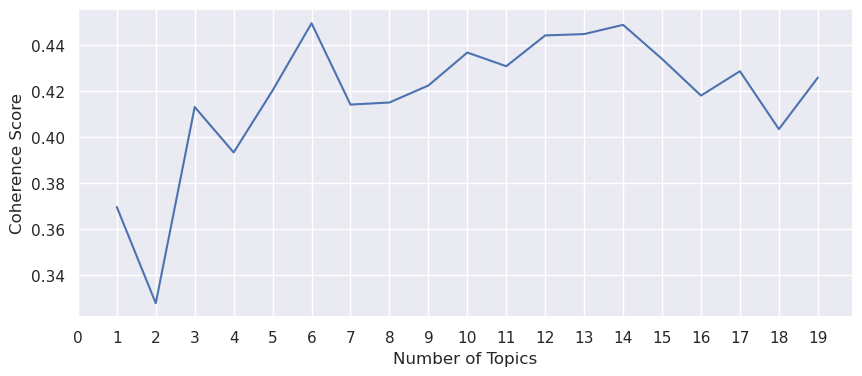

In [5]:
topic_df = pd.read_csv('../shared/topics.csv')
topic_df['new_index'] = [i+1 for i in topic_df.index]
topic_df.set_index('new_index', inplace=True)
ax=topic_df.plot(figsize=(10, 4))
ax.get_legend().remove()
ax.set_xlabel("Number of Topics")
ax.set_xticks(range(0,20))
ax.set_ylabel("Coherence Score")

# topics = []
# score = []
# for i in range(1,20,1):
#    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, random_state=42, iterations=10, num_topics=i, workers = 4, passes=10)
#    cm = CoherenceModel(model=lda_model, texts = wos_df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
#    topics.append(i)
#    score.append(cm.get_coherence())
#    print(i)
# _=plt.figure(figsize=(10, 4))
# _=plt.plot(topics, score)
# _=plt.xticks(range(0,20))
# _=plt.xlabel('Number of Topics')
# _=plt.ylabel('Coherence Score')
# plt.show()

Once the optimum number of topics has been found, the LDA for that number can be run again so that the results can be exxamined. According to the chart produced in the previous step, there are two candidates for the number of topics. The default code below uses the value 14 which on the one hand will result in a richer set of topics. On the other hand, some of the topics may be closely related from a semantic point of view. Using the lower value oif 6 topics, each topic will be broader but is likely to be more clearly differentiated from the others.

Greater detail and a clearer distinction between topics are both useful characteristics. Different situations call for different decisions and sometimes the best way to select the best approach for your context is to experiment.

In [6]:
number_of_topics = 14
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, random_state=42, iterations=50, num_topics=number_of_topics, workers = 4, passes=10)

### Step 5: Visualise topics

The Python package [pyLDAVis](https://pyldavis.readthedocs.io/en/latest/readme.html) provides a convenient ay to explore the results of an LDA analysis. In the imteractive diagram that is created, you can select one topic at a time and see the set of terms ordered by their significance. For the details of how this is worked out, please refer to the pyLDAVis documentation.

A feature of the interactive visualisation allows you to set the *relevance* parameter &lambda;. Again, a certain amount of experimentation is needed, but in general a value of &lambda; between around 0.6 and 1.0 gives the most accurate results. 

In [7]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/opt/tljh/user/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# Exercise 1: name the topics

The topics in the visualisation are identified using statistics and have placeholders *Topic 1*, *Topic 2*, etc.  as names. It is up to you as a human being to interpret the frequently-used terms in each topic to decide what they represent. Try to aim for topic names that are noun phrases of no more than five words.

Double-click the next cell to edit it and enter your topic names. Click *Run* in the toolbar when you are finished.

* **Topic 1**: your topic name here
* **Topic 2**:
* **Topic 3**:
* **Topic 4**:
* **Topic 5**:
* **Topic 6**:
* **Topic 7**:
* **Topic 8**:
* **Topic 9**:
* **Topic 10**:
* **Topic 11**:
* **Topic 12**:
* **Topic 13**:
* **Topic 14**:


### Show documents by topic

To examine the papers in each topic, we first need to associate each document with its primary topic number. Run the code below to do this.

In [8]:
wos_df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(wos_df['AB']))]
wos_df.topic.value_counts()

0     521
2     459
1     153
3     140
5      88
9      75
6      48
4      30
7      29
11     26
10     18
8      18
13      5
12      5
Name: topic, dtype: int64

However, note that the pyLDAVis visualisation numbers and orders the topic by the percentage coverage of the top 30 terms. In contrast, the underlying structure uses topic numbers based on the number of documents in each one.

You can check the correspondence between the topic numbers in the data structure with those in the visualisation by listing them using the code below and matching up the list of terms.

When listing items in a topic, remember to use the number from the model that corresponds to the topic in the visualisation.

In [9]:
lda_model.print_topics()

[(0,
  '0.022*"environmental" + 0.018*"study" + 0.016*"sustainability" + 0.015*"technology" + 0.015*"information" + 0.015*"practice" + 0.013*"research" + 0.013*"sustainable" + 0.010*"business" + 0.009*"impact"'),
 (1,
  '0.041*"system" + 0.021*"research" + 0.017*"univ" + 0.014*"model" + 0.013*"decision" + 0.013*"sustainable" + 0.009*"information" + 0.009*"university" + 0.009*"technology" + 0.009*"sustainability"'),
 (2,
  '0.029*"server" + 0.027*"algorithm" + 0.025*"consumption" + 0.017*"resource" + 0.015*"cloud" + 0.015*"power" + 0.014*"reduce" + 0.014*"propose" + 0.014*"application" + 0.013*"time"'),
 (3,
  '0.021*"technology" + 0.021*"datum" + 0.019*"iot" + 0.019*"system" + 0.018*"univ" + 0.015*"application" + 0.014*"device" + 0.013*"cloud" + 0.013*"dept" + 0.012*"smart"'),
 (4,
  '0.031*"datacenter" + 0.031*"renewable" + 0.026*"malaysia" + 0.019*"factor" + 0.016*"study" + 0.015*"adoption" + 0.013*"system" + 0.013*"solar" + 0.012*"power" + 0.011*"framework"'),
 (5,
  '0.050*"datum" 

Now you can list the documents by their main topic. Just set the topic number below and run the code. If the entry contains a digital object identifier (DOI), it is rendered as a URL that you can click. Some items do not have a DOI and you will need to search for them explicitly if you want to read them.

If you want to save a set of items, uncomment the line at the end. This will create a csv file containined the items in the topic.

For more display options with pandas dataframes, see the article on [Towards Data Science](https://towardsdatascience.com/6-tips-to-customize-the-display-of-your-pandas-data-frame-ce5a8caa7783)

In [42]:
topic_no = 10
pd.set_option('display.max_colwidth', None)
wos_df = wos_df.assign(short = lambda x: x['TI'].str.slice(stop=120))
wos_df = wos_df.assign(url = lambda x: 'https://dx.doi.org/' + x['DI'])
HTML(wos_df.loc[wos_df['topic'] == topic_no, ['short', 'url']].to_html(render_links=True))

# wos_df.loc[wos_df['topic'] == topic_no].to_csv('topic' + str(topic_no) + '.csv',  sep='\t', index=False, index_label=wos_df.columns)

,short,url
78,Collaborative and Autonomic Green computing track: CAGing 2012,https://dx.doi.org/10.1109/WETICE.2012.42
86,Track report of CAGing track of WETICE-2014,https://dx.doi.org/10.1109/WETICE.2014.48
183,Dark Silicon Considered Harmful: A Case for Truly Green Computing,NaN
315,Application of ISO/IEC 33000 to Green IT: A Case Study,https://dx.doi.org/10.1109/ACCESS.2019.2936451
334,A Governance and Management Framework for Green IT,https://dx.doi.org/10.3390/su9101761
337,A SPICE-Based Maturity Model for the Governance and Management of Green IT,https://dx.doi.org/10.1007/978-3-319-67383-7_11
345,Green IT Governance and Management based on ISO/IEC 15504,https://dx.doi.org/10.1016/j.csi.2018.04.005
354,Methodology for Green Certificates of Service Applications,https://dx.doi.org/10.1109/WETICE.2012.12
380,Auditing the Governance and Management of Green IT,https://dx.doi.org/10.1080/08874417.2021.1939198
435,Helping Programmers Improve the Energy Efficiency of Source Code,https://dx.doi.org/10.1109/ICSE-C.2017.80
